#SkillPay AI
## CV Tabanlı Maaş Tahmin Sistemi  
Bu projede, iş ilanları verileri kullanılarak bir adayın CV bilgilerine göre  
piyasada talep edebileceği maaş aralığı tahmin edilmektedir.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import joblib

## 1. Veri Setinin Yüklenmesi
Bu adımda Google Drive üzerinden Global AI Job Market veri seti yüklenmiştir.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ai_job_dataset1.csv")
df.head()

,job_id,job_title,salary_usd,salary_currency,salary_local,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,Data Scientist,219728,USD,219728,EX,PT,Sweden,M,Sweden,0,"Python, Computer Vision, R, Docker",Associate,13,Transportation,2024-09-23,2024-10-31,1132,6.6,TechCorp Inc
1,AI00002,Head of AI,230237,JPY,25326070,EX,PT,Japan,L,Japan,50,"Kubernetes, MLOps, Tableau, Python",Bachelor,10,Transportation,2024-07-26,2024-09-12,2299,8.5,Cloud AI Solutions
2,AI00003,Data Engineer,128890,EUR,109557,EX,CT,Germany,S,Germany,100,"Spark, Scala, Hadoop, PyTorch, GCP",Bachelor,12,Automotive,2025-01-19,2025-03-28,1329,5.5,Quantum Computing Inc
3,AI00004,Computer Vision Engineer,96349,USD,96349,MI,FL,Finland,L,Finland,50,"MLOps, Linux, Tableau, Python",PhD,2,Automotive,2024-07-20,2024-09-06,1132,6.8,Cognitive Computing
4,AI00005,Robotics Engineer,63065,EUR,53605,EN,FT,France,S,France,100,"R, Scala, SQL, GCP, Python",Associate,0,Finance,2025-03-16,2025-05-09,2011,9.3,Advanced Robotics


# 2. Veri Genel Kontrol (Initial Data Audit)

Bu adımda veri setinin temel yapısını doğruluyoruz.

Amaç:
- Veri boyutunu görmek (kaç satır, kaç feature)
- Duplicate kayıt var mı kontrol etmek
- job_id gerçekten benzersiz mi kontrol etmek

Bu kontrol, veri kalitesini anlamak için ilk adımdır.
Eğer duplicate veya kimlik problemi varsa model performansı yanıltıcı olur.

In [ ]:
print("Shape:", df.shape)
print("\nDuplicate rows:", df.duplicated().sum())
print("\nUnique job_id:", df["job_id"].nunique())

Shape: (15000, 20)

Duplicate rows: 0

Unique job_id: 15000


# 3. Eksik Değer Analizi (Missing Value Assessment)

Bu adımda eksik değer oranlarını inceliyoruz.

Amaç:
- Hangi feature'larda veri kaybı var görmek
- % kaç eksik değer var belirlemek
- İmputation mı yapacağız yoksa kolonu çıkaracak mıyız karar vermek

Eksik değer oranı %30’dan fazlaysa genellikle feature çıkarılabilir.
Düşük oranlarda ise uygun stratejiyle doldurulur (median, mode, model-based vs.)

In [ ]:
missing_pct = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
missing_pct[missing_pct > 0]

,0


# 4. Hedef Değişken Analizi (Target Variable Inspection)

Burada modelimizin tahmin edeceği değişken olan salary_usd'i inceliyoruz.

Amaç:
- Eksik değer var mı?
- Negatif ya da 0 maaş var mı?
- Minimum / maksimum değerleri görmek
- Ortalama ve medyan farkına bakarak dağılımın çarpıklığını anlamak

Eğer ortalama >> medyan ise dağılım sağa çarpık olabilir.
Bu durumda log dönüşümü düşünülebilir.

In [ ]:
print("Missing salary:", df["salary_usd"].isna().sum())
print("Min salary:", df["salary_usd"].min())
print("Max salary:", df["salary_usd"].max())
print("Mean salary:", df["salary_usd"].mean())
print("Median salary:", df["salary_usd"].median())

df["salary_usd"].describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99])

Missing salary: 0
Min salary: 16621
Max salary: 410273
Mean salary: 121991.93826666666
Median salary: 107261.5


,salary_usd
count,15000.000000
mean,121991.938267
std,63968.361846
min,16621.000000
1%,25560.000000
5%,43579.500000
10%,55228.000000
25%,74978.500000
50%,107261.500000
75%,155752.250000


# 5. Maaş Dağılımı Görselleştirmesi (Distribution Analysis)

Bu adımda salary_usd değişkeninin histogramını çiziyoruz.

Amaç:
- Maaş dağılımı normal mi yoksa sağa çarpık mı görmek
- Aykırı değer (outlier) var mı gözlemlemek
- Log transform gerekip gerekmediğine karar vermek

Çoğu maaş verisi sağa çarpıktır.
Bu durumda log transformation model performansını artırabilir.

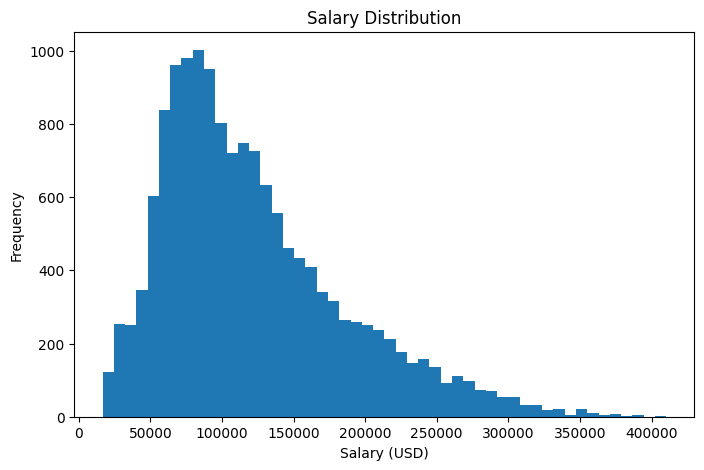

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df["salary_usd"], bins=50)
plt.title("Salary Distribution")
plt.xlabel("Salary (USD)")
plt.ylabel("Frequency")
plt.show()

# 6. Log Transformation of Target

Maaş dağılımı sağa çarpık olduğu için
model stabilitesini artırmak amacıyla
log transform uygulanacaktır.

Original Mean: 121991.93826666666
Log Mean: 11.57514826217086


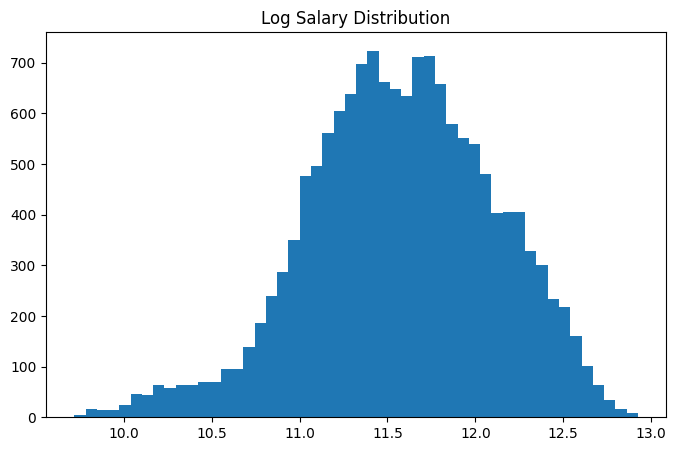

In [ ]:
df["log_salary"] = np.log1p(df["salary_usd"])

print("Original Mean:", df["salary_usd"].mean())
print("Log Mean:", df["log_salary"].mean())

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df["log_salary"], bins=50)
plt.title("Log Salary Distribution")
plt.show()

# 7. Skill Feature Engineering

required_skills kolonunu parçalayarak
her skill için binary (0/1) feature oluşturacağız.

Bu yaklaşım modele hangi skill maaşı artırıyor
yorumlama imkanı sağlar.

In [ ]:
# 1️⃣ Skill listesini temizle
df["required_skills"] = df["required_skills"].fillna("")

# 2️⃣ Tüm skillleri parçala
all_skills = set()

for skills in df["required_skills"]:
    for s in skills.split(","):
        all_skills.add(s.strip())

print("Toplam unique skill sayısı:", len(all_skills))

# 3️⃣ Multi-hot encoding
for skill in all_skills:
    df[f"skill_{skill}"] = df["required_skills"].apply(lambda x: 1 if skill in x else 0)

print("Skill feature eklendi ✅")
print("Yeni shape:", df.shape)

Toplam unique skill sayısı: 24
Skill feature eklendi ✅
Yeni shape: (15000, 45)


# 8. Categorical Feature Cardinality Check

Amaç:
- Hangi kategorik feature kaç farklı değer içeriyor görmek
- Yüksek cardinality varsa strateji belirlemek

In [ ]:
categorical_cols = [
    "experience_level",
    "employment_type",
    "company_location",
    "company_size",
    "education_required",
    "industry"
]

for col in categorical_cols:
    print(col, "->", df[col].nunique())

experience_level -> 4
employment_type -> 4
company_location -> 20
company_size -> 3
education_required -> 4
industry -> 15


# 9. Feature Matrix Hazırlama

Amaç:
- Model için X ve y oluşturmak
- Kullanılmayacak kolonları çıkarmak
- OneHot Encoding uygulamak

In [ ]:
from sklearn.model_selection import train_test_split

# 1️⃣ Kullanmayacağımız kolonlar
drop_cols = [
    "job_id",
    "salary_usd",
    "salary_currency",
    "salary_local",
    "required_skills",
    "company_name",
    "posting_date",
    "application_deadline"
]

df_model = df.drop(columns=drop_cols)

# 2️⃣ Target
y = df_model["log_salary"]
X = df_model.drop(columns=["log_salary"])

# 3️⃣ OneHot Encoding
X = pd.get_dummies(X, drop_first=True)

print("Final Feature Shape:", X.shape)

Final Feature Shape: (15000, 140)


# 10. Train/Test Split

Amaç:
- Modeli eğitmek için train set
- Performansı ölçmek için test set oluşturmak

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (12000, 140)
Test shape: (3000, 140)


# 11. Baseline Model - Linear Regression

Amaç:
- Baseline performans görmek
- Log scale RMSE hesaplamak
- Gerçek maaş RMSE hesaplamak

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Tahmin (log scale)
y_pred_log = lr.predict(X_test)

# Log RMSE
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
mae_log = mean_absolute_error(y_test, y_pred_log)

print("Log RMSE:", rmse_log)
print("Log MAE:", mae_log)

# Gerçek maaşa geri çevir
y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
mae_real = mean_absolute_error(y_test_real, y_pred_real)

print("\nReal Salary RMSE:", rmse_real)
print("Real Salary MAE:", mae_real)

Log RMSE: 0.14048801824569238
Log MAE: 0.1194217222514338

Real Salary RMSE: 20797.660335623998
Real Salary MAE: 15172.73591506121


# 12. Random Forest Model
Amaç:
- Non-linear model performansını görmek
- Linear ile karşılaştırmak

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_log_rf = rf.predict(X_test)

rmse_log_rf = np.sqrt(mean_squared_error(y_test, y_pred_log_rf))
mae_log_rf = mean_absolute_error(y_test, y_pred_log_rf)

print("RF Log RMSE:", rmse_log_rf)
print("RF Log MAE:", mae_log_rf)

# Real scale
y_pred_real_rf = np.expm1(y_pred_log_rf)

rmse_real_rf = np.sqrt(mean_squared_error(y_test_real, y_pred_real_rf))
mae_real_rf = mean_absolute_error(y_test_real, y_pred_real_rf)

print("\nRF Real RMSE:", rmse_real_rf)
print("RF Real MAE:", mae_real_rf)

RF Log RMSE: 0.1467468087220791
RF Log MAE: 0.12283593408296417

RF Real RMSE: 21801.670118714308
RF Real MAE: 15523.988528199026


# 12. Ridge Regression (Regularized Linear Model)

Bu adımda Linear Regression modelini L2 regularization ile güçlendiriyoruz.

Amaç:
- Çok sayıda feature olduğu için multicollinearity etkisini azaltmak
- Overfitting riskini düşürmek
- Daha stabil ve genellenebilir bir model elde etmek

Ridge Regression, özellikle:
- OneHot encoding sonrası artan feature sayısında
- Korelasyonlu değişkenler bulunduğunda
daha iyi performans verebilir.

Bu modelin performansını Linear Regression ile karşılaştıracağız.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Log scale prediction
y_pred_log_ridge = ridge.predict(X_test)

rmse_log_ridge = np.sqrt(mean_squared_error(y_test, y_pred_log_ridge))
mae_log_ridge = mean_absolute_error(y_test, y_pred_log_ridge)

print("Ridge Log RMSE:", rmse_log_ridge)
print("Ridge Log MAE:", mae_log_ridge)

# Real salary scale
y_pred_real_ridge = np.expm1(y_pred_log_ridge)
y_test_real = np.expm1(y_test)

rmse_real_ridge = np.sqrt(mean_squared_error(y_test_real, y_pred_real_ridge))
mae_real_ridge = mean_absolute_error(y_test_real, y_pred_real_ridge)

print("\nRidge Real RMSE:", rmse_real_ridge)
print("Ridge Real MAE:", mae_real_ridge)

Ridge Log RMSE: 0.14049107164051813
Ridge Log MAE: 0.11944525912759048

Ridge Real RMSE: 20801.927201630162
Ridge Real MAE: 15175.425197729488


# 13. Feature Importance (Linear Coefficients)

Amaç:
- Hangi feature maaşı artırıyor görmek
- Hangi skill daha değerli analiz etmek

In [ ]:
import pandas as pd

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": lr.coef_
})

coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

coef_df.head(20)

,feature,coefficient,abs_coef
47,experience_level_EX,1.096280,1.096280
60,company_location_India,-1.053462,1.053462
55,company_location_China,-0.761959,0.761959
49,experience_level_SE,0.666863,0.666863
69,company_location_Switzerland,0.338235,0.338235
48,experience_level_MI,0.329389,0.329389
65,company_location_Norway,0.247831,0.247831
73,company_size_S,-0.244568,0.244568
56,company_location_Denmark,0.236540,0.236540
67,company_location_South Korea,-0.199951,0.199951


# 14. Katsayıları % Etkiye Çevirme (Daha Anlaşılır Yorum)

Bu adımda Linear model katsayılarını log-ölçekten çıkarıp yaklaşık yüzde etki olarak yorumluyoruz.
Formül:
- multiplier = exp(coef)
- percent_effect = (exp(coef)-1)*100

In [ ]:
import numpy as np
import pandas as pd

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef_log": lr.coef_
})
coef_df["multiplier"] = np.exp(coef_df["coef_log"])
coef_df["percent_effect"] = (coef_df["multiplier"] - 1) * 100
coef_df["abs_coef"] = coef_df["coef_log"].abs()

coef_df.sort_values("abs_coef", ascending=False).head(20)

,feature,coef_log,multiplier,percent_effect,abs_coef
47,experience_level_EX,1.096280,2.993010,199.301030,1.096280
60,company_location_India,-1.053462,0.348728,-65.127159,1.053462
55,company_location_China,-0.761959,0.466751,-53.324877,0.761959
49,experience_level_SE,0.666863,1.948116,94.811633,0.666863
69,company_location_Switzerland,0.338235,1.402470,40.247013,0.338235
48,experience_level_MI,0.329389,1.390119,39.011852,0.329389
65,company_location_Norway,0.247831,1.281244,28.124394,0.247831
73,company_size_S,-0.244568,0.783043,-21.695736,0.244568
56,company_location_Denmark,0.236540,1.266858,26.685837,0.236540
67,company_location_South Korea,-0.199951,0.818771,-18.122890,0.199951


# 15. Modeli ve Feature Kolonlarını Kaydetme

Bu adımda modeli ve eğitimde kullanılan feature kolon sırasını kaydediyoruz.

Neden gerekli?
- Arayüzde kullanıcıdan gelen veriyi aynı feature kolonlarına dönüştürmemiz gerekiyor.
- Aksi halde kolon sırası uyuşmaz ve model hatalı tahmin üretir.

Çıktı:
- salary_model_artifact.joblib (model + feature_columns)

In [ ]:
import joblib

artifact = {
    "model": lr,
    "feature_columns": X.columns.tolist()
}

joblib.dump(artifact, "salary_model_artifact.joblib")
print("Saved -> salary_model_artifact.joblib ✅")

Saved -> salary_model_artifact.joblib ✅


# 16. Arayüz İçin Skill Listesini Hazırlama

Bu adımda arayüzde dropdown/checkbox olarak gösterebilmek için tüm skill isimlerini çıkarıyoruz.

Çıktı:
- skill_names: kullanıcı arayüzünde seçilecek skill listesi

In [ ]:
skill_cols = [c for c in df.columns if c.startswith("skill_")]
skill_names = [c.replace("skill_", "") for c in skill_cols]

print("Skill count:", len(skill_names))
print("Skills:", skill_names)

Skill count: 24
Skills: ['Statistics', 'Git', 'GCP', 'Scala', 'Kubernetes', 'Computer Vision', 'NLP', 'Data Visualization', 'Tableau', 'Java', 'Hadoop', 'Docker', 'MLOps', 'TensorFlow', 'Azure', 'Mathematics', 'AWS', 'Linux', 'PyTorch', 'SQL', 'Spark', 'Deep Learning', 'R', 'Python']


# 17. Cross-Validation ile Model Değerlendirme

Tek bir train/test split şansa bağlı sonuç üretebilir. K-Fold Cross-Validation ile modelin genellenebilirliğini ölçeriz.

Amaç:
- 5-fold CV ile log-scale RMSE/MAE ortalama ± std görmek
- Model performansının stabil olup olmadığını anlamak

In [ ]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    "mae": make_scorer(mean_absolute_error, greater_is_better=False),
    "rmse": make_scorer(rmse, greater_is_better=False)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

lr_cv = LinearRegression()
cv_results = cross_validate(
    lr_cv, X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

mae_scores = -cv_results["test_mae"]
rmse_scores = -cv_results["test_rmse"]

print("CV Log-MAE  mean±std:", mae_scores.mean(), "±", mae_scores.std())
print("CV Log-RMSE mean±std:", rmse_scores.mean(), "±", rmse_scores.std())

CV Log-MAE  mean±std: 0.11997467443925833 ± 0.001257460700960641
CV Log-RMSE mean±std: 0.14130223421872018 ± 0.0015420177305446104


# 18. Test Set Hata Analizi (Error Diagnostics)

Yalnızca genel metrik yetmez.
Modelin hangi segmentlerde (ülke, seviye, sektör) daha kötü olduğunu görmeliyiz.

Amaç:
- Test setinde gerçek maaş ölçeğinde absolute error hesaplamak
- experience_level, company_location, industry bazında hata karşılaştırmak
- En problemli segmentleri yakalamak

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Test tahmini (log -> real)
y_pred_log = lr.predict(X_test)
y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

# Test indexleri ile original df'den segment bilgilerini çekelim
# Not: X, df_model ve df aynı sıradaysa çalışır. Biz split'i X üzerinden yaptığımız için index tutarlı olmalı.
test_idx = X_test.index

diag = df.loc[test_idx, ["experience_level", "company_location", "industry"]].copy()
diag["y_true"] = y_test_real
diag["y_pred"] = y_pred_real
diag["abs_error"] = np.abs(diag["y_true"] - diag["y_pred"])

print("Overall Test Real MAE:", diag["abs_error"].mean())
print("Overall Test Real RMSE:", np.sqrt(np.mean((diag["y_true"] - diag["y_pred"])**2)))

def segment_report(col, top_n=8):
    rep = diag.groupby(col).agg(
        count=("abs_error","size"),
        mae=("abs_error","mean"),
        median_ae=("abs_error","median")
    ).sort_values("mae", ascending=False)

    # çok az örnekli segmentler yanıltmasın diye count>=30 filtre (istersen değiştir)
    rep = rep[rep["count"] >= 30].head(top_n)
    return rep

display(segment_report("experience_level"))
display(segment_report("company_location"))
display(segment_report("industry"))

Overall Test Real MAE: 15172.73591506121
Overall Test Real RMSE: 20797.660335623998


,count,mae,median_ae
experience_level,,,
EX,767,30113.900732,28924.727668
SE,743,13264.786117,12604.004169
MI,769,9327.811905,8441.033800
EN,721,7478.533209,7098.303943


,count,mae,median_ae
company_location,,,
Norway,114,20515.561931,16160.175329
Switzerland,169,20147.291450,14441.075573
Denmark,147,20072.397125,15900.448610
United States,149,18636.148031,14865.162348
Netherlands,143,17692.403681,11889.345680
Ireland,176,16734.922415,12374.989117
Japan,134,16023.356467,11962.876679
France,161,15741.754648,10765.000429


,count,mae,median_ae
industry,,,
Education,198,16652.870737,12110.378594
Automotive,207,16296.178278,11767.207967
Finance,198,16280.046322,11696.187983
Manufacturing,204,15455.079712,11454.760152
Energy,187,15313.113949,11543.374507
Technology,230,15291.258629,10725.347313
Healthcare,183,15244.744954,11235.733128
Government,207,15207.611122,10993.710270


# 19. Data-Driven Maaş Aralığı (Residual-based Prediction Interval)

Şu ana kadar aralık için ±1.5*MAE gibi heuristic kullandık.
Aralığı veriden öğreniriz.

Amaç:
- Train set residual dağılımını kullanarak percentil tabanlı aralık üretmek
- Örn: %10-%90 aralığı veya %5-%95 aralığı
Not:
- Bu "prediction interval" tam istatistiksel garanti vermez ama heuristic'ten daha sağlamdır.

In [ ]:
import numpy as np

# Train residuals (real scale)
y_train_pred_log = lr.predict(X_train)
y_train_pred_real = np.expm1(y_train_pred_log)
y_train_real = np.expm1(y_train)

residuals = y_train_real - y_train_pred_real  # signed

p10 = np.percentile(residuals, 10)
p90 = np.percentile(residuals, 90)
p05 = np.percentile(residuals, 5)
p95 = np.percentile(residuals, 95)

print("Residual percentiles:")
print("10th:", p10, " 90th:", p90)
print("5th :", p05, " 95th :", p95)

Residual percentiles:
10th: -20563.596408130583  90th: 23896.828726553707
5th : -32994.655531888224  95th : 39958.0292288162


# 20. Final Model Packaging (Senior Production Standard)

Bu adımda modeli production-ready hale getiriyoruz.

Amaç:
- Eğitilmiş modeli kaydetmek
- Feature kolon sırasını saklamak
- Skill listesini saklamak
- Data-driven prediction interval istatistiklerini saklamak
- Arayüz ve deployment tarafında tekrar üretilebilirlik sağlamak

Neden gerekli?


- Reproducible (tekrar üretilebilir)
- Version-controlled
- Deployment-ready
- Stable feature alignment garantili

olmalıdır.

Bu adımda model + preprocessing bilgileri tek bir artifact dosyasında saklanır.

Kaydedilen bilgiler:
- Trained Linear Regression modeli
- Feature kolon listesi
- Skill listesi
- Residual dağılım percentilleri (interval hesaplamak için)
- Model metrikleri (CV sonuçları)

Bu sayede:
- UI tarafında güvenli tahmin yapılır
- Başka bir ortamda model yeniden yüklenebilir
- Model versiyonlanabilir

In [ ]:
import joblib

final_artifact = {
    "model": lr,
    "feature_columns": X.columns.tolist(),
    "skills": skill_names,
    "metrics": {
        "cv_log_mae_mean": float(mae_scores.mean()),
        "cv_log_mae_std": float(mae_scores.std()),
        "cv_log_rmse_mean": float(rmse_scores.mean()),
        "cv_log_rmse_std": float(rmse_scores.std()),
    },
    "interval": {
        "p10": float(p10),
        "p90": float(p90),
        "p05": float(p05),
        "p95": float(p95),
    }
}

joblib.dump(final_artifact, "salary_model_artifact_final.joblib")

print("✅ Final artifact saved as salary_model_artifact_final.joblib")

✅ Final artifact saved as salary_model_artifact_final.joblib


# 21. SkillPay AI — Final CV UI (Final Artifact + Data-driven Intervals)

Bu adımda SkillPay AI'nin final arayüzünü yayına alıyoruz.

Amaç:
- salary_model_artifact_final.joblib dosyasından:
  - modeli
  - feature kolonlarını
  - skill listesini
  - residual percentil interval istatistiklerini
  yüklemek
- CV metninden:
  - skills
  - years_experience
  - education
  - auto experience level
  çıkarmak
- Tahmin sonucunu:
  - Point estimate
  - %80 prediction interval (p10–p90)
  - %90 prediction interval (p05–p95)
  olarak göstermek

Bu, projenin deploy edilebilir final halidir.

In [ ]:
!pip install gradio joblib -q

import joblib
import gradio as gr
import numpy as np
import pandas as pd
import re
from datetime import datetime

# =========================
# 1) Load FINAL artifact
# =========================
artifact = joblib.load("salary_model_artifact_final.joblib")
model = artifact["model"]
feature_columns = artifact["feature_columns"]
skill_names = artifact["skills"]

p10 = artifact["interval"]["p10"]
p90 = artifact["interval"]["p90"]
p05 = artifact["interval"]["p05"]
p95 = artifact["interval"]["p95"]

# df notebook'ta yüklü olmalı
company_locations = sorted(df["company_location"].unique())
company_sizes = sorted(df["company_size"].unique())
employment_types = sorted(df["employment_type"].unique())
industries = sorted(df["industry"].unique())
education_levels = sorted(df["education_required"].unique())

# CV'den çıkarması zor alanlar için default (median)
default_benefits = float(df["benefits_score"].median())
default_jd_len = int(df["job_description_length"].median())

# =========================
# 2) CV Parsers
# =========================
current_year = datetime.now().year
SKILL_PATTERNS = {s: re.compile(rf"\b{re.escape(s)}\b", re.IGNORECASE) for s in skill_names}

def extract_skills(text: str):
    text = text or ""
    return sorted({s for s, pat in SKILL_PATTERNS.items() if pat.search(text)})

def is_internship(text: str):
    t = (text or "").lower()
    return bool(re.search(r"\bintern\b|\binternship\b|\bstaj\b|\bstajyer\b", t))

def extract_years_experience(text: str):
    """
    Senior version: tarih aralıklarını TOPLAR.
    - 2016-2019 + 2019-present => total
    - since 2019 => fallback
    - "3 years" => fallback
    - internship/staj varsa 1 yıl düşürür
    """
    t = (text or "").lower()
    total_years = 0

    # 2018-2022, 2019 – present
    range_matches = re.findall(
        r"(19\d{2}|20\d{2})\s*[-–]\s*(19\d{2}|20\d{2}|present|now|günümüz|halen)",
        t
    )

    for start, end in range_matches:
        s = int(start)
        e = current_year if end in ["present", "now", "günümüz", "halen"] else int(end)
        if 1990 <= s <= current_year and 1990 <= e <= current_year and e >= s:
            total_years += (e - s)

    # since 2019 (range yoksa destek)
    if total_years == 0:
        for y in re.findall(r"since\s+(19\d{2}|20\d{2})", t):
            yy = int(y)
            if 1990 <= yy <= current_year:
                total_years = max(total_years, current_year - yy)

    # "3 years" / "2 yıl" fallback
    if total_years == 0:
        explicit = re.findall(r"(\d{1,2})\s*(years|year|yrs|yıl|yil)", t)
        if explicit:
            total_years = int(explicit[0][0])

    # internship penalty
    if is_internship(t):
        total_years = max(0, total_years - 1)

    return int(np.clip(total_years, 0, 20))

def detect_education(text: str):
    t = (text or "").lower()
    if re.search(r"\bphd\b|\bdoctorate\b|\bdoktora\b", t):
        return "PhD" if "PhD" in education_levels else education_levels[-1]
    if re.search(r"\bmaster\b|\bm\.sc\b|\byüksek lisans\b|\byuksek lisans\b", t):
        return "Master" if "Master" in education_levels else "Bachelor"
    if re.search(r"\bbachelor\b|\bb\.sc\b|\blisans\b", t):
        return "Bachelor" if "Bachelor" in education_levels else education_levels[0]
    if re.search(r"\bassociate\b|\bönlisans\b|\bonlisans\b", t):
        return "Associate" if "Associate" in education_levels else education_levels[0]
    return education_levels[0] if education_levels else "Bachelor"

def auto_experience_level(years: int):
    if years <= 1: return "EN"
    if years <= 4: return "MI"
    if years <= 8: return "SE"
    return "EX"

# =========================
# 3) Final predict (interval + annual/monthly/hourly)
# =========================
def predict_from_cv(cv_text, company_location, industry, company_size, employment_type, remote_ratio):
    skills = extract_skills(cv_text)
    years_exp = extract_years_experience(cv_text)
    edu = detect_education(cv_text)
    exp_level = auto_experience_level(years_exp)

    input_dict = {col: 0 for col in feature_columns}

    # numeric
    if "years_experience" in input_dict: input_dict["years_experience"] = years_exp
    if "remote_ratio" in input_dict: input_dict["remote_ratio"] = int(remote_ratio)
    if "benefits_score" in input_dict: input_dict["benefits_score"] = default_benefits
    if "job_description_length" in input_dict: input_dict["job_description_length"] = default_jd_len

    # skills
    for s in skills:
        col = f"skill_{s}"
        if col in input_dict:
            input_dict[col] = 1

    # one-hot categoricals (varsa)
    for k in [
        f"experience_level_{exp_level}",
        f"employment_type_{employment_type}",
        f"company_location_{company_location}",
        f"company_size_{company_size}",
        f"education_required_{edu}",
        f"industry_{industry}",
    ]:
        if k in input_dict:
            input_dict[k] = 1

    X_in = pd.DataFrame([input_dict])

    log_pred = float(model.predict(X_in)[0])
    annual = float(np.expm1(log_pred))

    # intervals (annual)
    low80 = max(0, annual + p10)
    high80 = annual + p90
    low90 = max(0, annual + p05)
    high90 = annual + p95

    # monthly/hourly
    monthly = annual / 12
    hourly = annual / 2080  # ~40h/week * 52 weeks

    result_md = f"""
### 💰 SkillPay AI Salary Estimate (Annual, USD)
**${annual:,.0f}**

**Monthly equivalent:** ${monthly:,.0f}
**Hourly equivalent (≈2080h/year):** ${hourly:,.2f}

### 📊 80% Prediction Interval (Annual)
**${low80:,.0f} — ${high80:,.0f}**

### 📊 90% Prediction Interval (Annual)
**${low90:,.0f} — ${high90:,.0f}**

<small>Intervals are derived from empirical residual distribution (train residual percentiles).</small>
"""

    extracted_md = f"""
### ✅ Extracted from CV
- **Skills ({len(skills)}):** {", ".join(skills) if skills else "None found"}
- **Estimated Experience:** {years_exp} year(s)
- **Auto Experience Level:** {exp_level}
- **Detected Education:** {edu}
"""

    return result_md, extracted_md

# =========================
# 4) Modern UI
# =========================
css = """
.gradio-container { max-width: 1100px !important; }
#title h1 { letter-spacing: -0.6px; margin-bottom: 4px; }
#title p { margin-top: 0px; opacity: 0.8; }
textarea { font-size: 14px !important; line-height: 1.4 !important; }
"""

theme = gr.themes.Soft(primary_hue="orange", radius_size="lg", font=["Inter", "ui-sans-serif", "system-ui"])

with gr.Blocks(theme=theme, css=css, title="SkillPay AI") as demo:
    gr.Markdown(
        """
<div id="title">
  <h1>SkillPay AI</h1>
  <p>Paste your CV → skills & experience extracted → salary estimate with prediction intervals.</p>
</div>
        """
    )

    with gr.Row():
        with gr.Column(scale=7):
            cv_text = gr.Textbox(
                label="CV Text",
                placeholder="Paste your CV here (English or Turkish)...",
                lines=18
            )
            with gr.Row():
                btn = gr.Button("Predict", variant="primary")
                clr = gr.Button("Clear", variant="secondary")

        with gr.Column(scale=5):
            result = gr.Markdown()
            extracted = gr.Markdown()

            with gr.Accordion("Optional settings", open=False):
                company_location = gr.Dropdown(company_locations, value=company_locations[0], label="Company Location")
                industry = gr.Dropdown(industries, value=industries[0], label="Industry")
                company_size = gr.Dropdown(company_sizes, value=company_sizes[0], label="Company Size")
                employment_type = gr.Dropdown(employment_types, value=employment_types[0], label="Employment Type")
                remote_ratio = gr.Slider(0, 100, step=10, value=0, label="Remote Ratio (%)")

    btn.click(
        fn=predict_from_cv,
        inputs=[cv_text, company_location, industry, company_size, employment_type, remote_ratio],
        outputs=[result, extracted]
    )

    def _clear():
        return "", "", ""

    clr.click(fn=_clear, inputs=[], outputs=[cv_text, result, extracted])

demo.launch()

/tmp/ipython-input-200680729.py:196: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=theme, css=css, title="SkillPay AI") as demo:
/tmp/ipython-input-200680729.py:196: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(theme=theme, css=css, title="SkillPay AI") as demo:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0385f6a8fe93d63f60.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 22. SHAP Explainability (Global + Local)

Bu adımda modelin kararlarını açıklıyoruz.

Neden gerekli?
Bir ML sistemi sadece tahmin üretmez, aynı zamanda:
- "Neden böyle tahmin etti?" sorusuna cevap verir.
- Hangi feature'lar maaşı artırıyor/azaltıyor gösterir.
- Modelin yanlış öğrenmiş olabileceği pattern'leri yakalamayı sağlar.

Çıktılar:
1) Global importance (SHAP bar/summary)
2) Local explanation (tek örnek için top katkılar tablosu)

In [ ]:
!pip install shap -q
import shap
import pandas as pd
import numpy as np
import joblib

In [ ]:
# Final artifact yükle
artifact = joblib.load("salary_model_artifact_final.joblib")
model = artifact["model"]
feature_columns = artifact["feature_columns"]

# X_train, X_test notebook'ta var kabul ediyoruz (senin akışında var)
# Eğer yoksa: X_train/X_test oluşturan split hücreni çalıştırman gerekir.

# SHAP için background (masker) seçiyoruz: train'den küçük örnek
background = shap.sample(X_train, 200, random_state=42)

# Linear model için en stabil seçenek:
explainer = shap.LinearExplainer(model, background, feature_perturbation="interventional")
print("SHAP explainer ready ✅")

SHAP explainer ready ✅


/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


## 22A. Global SHAP Importance

Bu grafikler modelin genel davranışını özetler:
- Hangi feature'lar maaş tahminini en çok etkiliyor?
- Etki pozitif mi negatif mi?

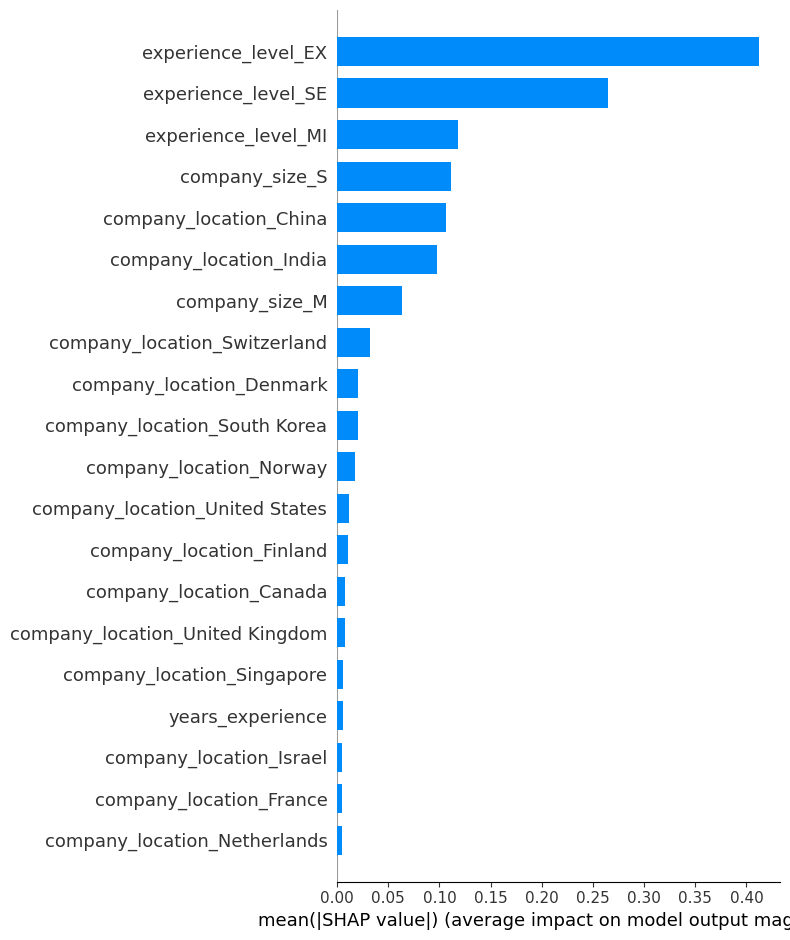

In [ ]:
# Test setten küçük bir örnek al (grafikler hızlı olsun)
X_vis = shap.sample(X_test, 1000, random_state=42)

shap_values = explainer.shap_values(X_vis)

# Global bar plot (en önemli feature'lar)
shap.summary_plot(shap_values, X_vis, plot_type="bar")

## 22B. Local SHAP Explanation

Bu adımda tek bir örnek için:
- Maaşı en çok artıran 10 feature
- Maaşı en çok azaltan 10 feature
tablo halinde gösterilir.

Özellikle CV arayüzünden gelen bir tahmini açıklamak için kullanacağız.

In [ ]:
def local_shap_explain(X_row: pd.DataFrame, top_k: int = 10):
    """
    X_row: 1 satırlık DataFrame (feature_columns ile aynı kolon düzeninde)
    """
    sv = explainer.shap_values(X_row)[0]  # 1 row
    df_exp = pd.DataFrame({
        "feature": X_row.columns,
        "value": X_row.iloc[0].values,
        "shap": sv
    })
    df_exp["abs_shap"] = df_exp["shap"].abs()
    df_exp = df_exp.sort_values("abs_shap", ascending=False)

    inc = df_exp[df_exp["shap"] > 0].head(top_k)
    dec = df_exp[df_exp["shap"] < 0].head(top_k)

    return inc, dec, df_exp.head(30)

# Örnek: test setten 1 satır açıklayalım
one = X_test.iloc[[0]].copy()
inc, dec, top30 = local_shap_explain(one, top_k=10)

print("Top increases (salary up):")
display(inc)

print("Top decreases (salary down):")
display(dec)

Top increases (salary up):


,feature,value,shap,abs_shap
47,experience_level_EX,True,0.82221,0.82221
55,company_location_China,False,0.076196,0.076196
60,company_location_India,False,0.063208,0.063208
72,company_size_M,False,0.047559,0.047559
63,company_location_Japan,True,0.042526,0.042526
129,industry_Finance,True,0.010116,0.010116
67,company_location_South Korea,False,0.009998,0.009998
57,company_location_Finland,False,0.006481,0.006481
51,employment_type_FT,True,0.006433,0.006433
54,company_location_Canada,False,0.003902,0.003902


Top decreases (salary down):


,feature,value,shap,abs_shap
49,experience_level_SE,False,-0.200059,0.200059
73,company_size_S,True,-0.154078,0.154078
48,experience_level_MI,False,-0.062584,0.062584
69,company_location_Switzerland,False,-0.016912,0.016912
78,employee_residence_Canada,True,-0.010877,0.010877
65,company_location_Norway,False,-0.009913,0.009913
56,company_location_Denmark,False,-0.009462,0.009462
28,job_title_AI Consultant,True,-0.009198,0.009198
1,years_experience,13,-0.007626,0.007626
10,skill_NLP,1,-0.006012,0.006012


# 21. SkillPay AI — Final CV UI + Explain (SHAP)

Bu adımda arayüz final artifact ile çalışır ve SHAP explainability sağlar.

Çıktılar:
- Salary (Annual USD) + Monthly + Hourly
- %80 ve %90 prediction interval
- CV'den çıkarılan bilgiler
- "Why this salary?" (Top + / - etkileyen feature'lar)

In [ ]:
!pip install gradio joblib shap -q

import joblib
import gradio as gr
import numpy as np
import pandas as pd
import re
from datetime import datetime
import shap

# =========================
# 1) Load FINAL artifact
# =========================
artifact = joblib.load("salary_model_artifact_final.joblib")
model = artifact["model"]
feature_columns = artifact["feature_columns"]
skill_names = artifact["skills"]

p10 = artifact["interval"]["p10"]
p90 = artifact["interval"]["p90"]
p05 = artifact["interval"]["p05"]
p95 = artifact["interval"]["p95"]

# df notebook'ta yüklü olmalı
company_locations = sorted(df["company_location"].unique())
company_sizes = sorted(df["company_size"].unique())
employment_types = sorted(df["employment_type"].unique())
industries = sorted(df["industry"].unique())
education_levels = sorted(df["education_required"].unique())

default_benefits = float(df["benefits_score"].median())
default_jd_len = int(df["job_description_length"].median())

# =========================
# 2) Build SHAP explainer ONCE
# =========================
background = shap.sample(X_train, 200, random_state=42)
explainer = shap.LinearExplainer(model, background, feature_perturbation="interventional")

# =========================
# 3) CV Parsers (FIXED & OPTIMIZED)
# =========================
current_year = datetime.now().year
current_month = datetime.now().month

SKILL_PATTERNS = {s: re.compile(rf"\b{re.escape(s)}\b", re.IGNORECASE) for s in skill_names}

def extract_skills(text: str):
    text = text or ""
    return sorted({s for s, pat in SKILL_PATTERNS.items() if pat.search(text)})

def is_internship(text: str):
    t = (text or "").lower()
    return bool(re.search(r"\bintern\b|\binternship\b|\bstaj\b|\bstajyer\b", t))

def _get_experience_section(text: str) -> str:
    t = text or ""
    start_patterns = [
        r"\bWORK EXPERIENCE\b", r"\bPROFESSIONAL EXPERIENCE\b", r"\bEXPERIENCE\b",
        r"\bDENEYİM\b", r"\bİŞ DENEYİMİ\b", r"\bIS DENEYIMI\b"
    ]
    end_patterns = [
        r"\bEDUCATION\b", r"\bEĞİTİM\b", r"\bEGITIM\b",
        r"\bPROJECTS\b", r"\bPROJELER\b", r"\bSKILLS\b",
        r"\bCERTIFICATES\b", r"\bSERTİFİKALAR\b"
    ]
    start_idx = None
    for sp in start_patterns:
        m = re.search(sp, t, flags=re.IGNORECASE)
        if m:
            start_idx = m.start()
            break
    if start_idx is None: return t
    sub = t[start_idx:]
    end_idx = None
    for ep in end_patterns:
        m2 = re.search(ep, sub, flags=re.IGNORECASE)
        if m2 and m2.start() > 5:
            end_idx = m2.start()
            break
    return sub if end_idx is None else sub[:end_idx]

MONTH_MAP = {
    "ocak":1, "şubat":2, "subat":2, "mart":3, "nisan":4, "mayıs":5, "mayis":5, "haziran":6,
    "temmuz":7, "ağustos":8, "agustos":8, "eylül":9, "eylul":9, "ekim":10, "kasım":11, "kasim":11, "aralık":12, "aralik":12,
    "january":1, "february":2, "march":3, "april":4, "may":5, "june":6, "july":7, "august":8,
    "september":9, "october":10, "november":11, "december":12,
    "jan":1, "feb":2, "mar":3, "apr":4, "jun":6, "jul":7, "aug":8, "sep":9, "sept":9, "oct":10, "nov":11, "dec":12
}

PRESENT_TOKENS = ["present", "now", "günümüz", "halen", "devam ediyor"]

MONTH_TOKEN = r"(?:ocak|şubat|subat|mart|nisan|mayıs|mayis|haziran|temmuz|ağustos|agustos|eylül|eylul|ekim|kasım|kasim|aralık|aralik|" \
              r"january|february|march|april|may|june|july|august|september|october|november|december|" \
              r"jan|feb|mar|apr|jun|jul|aug|sep|sept|oct|nov|dec)"

YEAR_RANGE_PAT = re.compile(
    rf"(?P<sy>19\d{{2}}|20\d{{2}})\s*[-–]\s*(?P<ey>19\d{{2}}|20\d{{2}}|{'|'.join(PRESENT_TOKENS)})",
    flags=re.IGNORECASE
)

MONTH_RANGE_PAT = re.compile(
    rf"(?P<sm>{MONTH_TOKEN})\s+(?P<sy>20\d{{2}})\s*[-–]\s*(?P<em>{MONTH_TOKEN}|{'|'.join(PRESENT_TOKENS)})\s*(?P<ey>20\d{{2}})?",
    flags=re.IGNORECASE
)

def extract_years_experience(text: str):
    full = (text or "").lower()
    exp_section = _get_experience_section(text)
    total_months = 0
    found_ranges = []

    # 1. AY-YIL formatı (Öncelikli)
    for m in MONTH_RANGE_PAT.finditer(exp_section or ""):
        sm_raw = m.group("sm").lower()
        sy = int(m.group("sy"))
        em_raw = m.group("em").lower()
        ey_raw = m.group("ey")
        sm = MONTH_MAP.get(sm_raw, 1)
        if em_raw in PRESENT_TOKENS:
            em, ey = current_month, current_year
        else:
            em = MONTH_MAP.get(em_raw, 1)
            ey = int(ey_raw) if ey_raw else sy
        diff = (ey - sy) * 12 + (em - sm)
        if diff > 0 and 1990 <= sy <= current_year:
            total_months += diff
            found_ranges.append((sy, ey))

    # 2. YIL-YIL formatı (Eğer ay-yıl tarafından yakalanmadıysa)
    for m in YEAR_RANGE_PAT.finditer(exp_section or ""):
        sy = int(m.group("sy"))
        ey_raw = m.group("ey").lower()
        ey = current_year if ey_raw in PRESENT_TOKENS else int(ey_raw)
        if not any(r[0] == sy and r[1] == ey for r in found_ranges):
            if 1990 <= sy <= current_year and ey >= sy:
                total_months += (ey - sy) * 12

    # 3. Fallback
    if total_months == 0:
        explicit = re.search(r"(\d{1,2})\s*(years|year|yrs|yıl|yil)", exp_section or "", flags=re.IGNORECASE)
        if explicit:
            years = int(explicit.group(1))
            return int(np.clip(years - 1 if is_internship(full) else years, 0, 20))
        return 0

    years = total_months / 12.0
    if is_internship(full): years = max(0, years - 1)
    return int(np.clip(round(years), 0, 20))

def detect_education(text: str):
    t = (text or "").lower()
    if re.search(r"\bphd\b|\bdoctorate\b|\bdoktora\b", t):
        return "PhD" if "PhD" in education_levels else education_levels[-1]
    if re.search(r"\bmaster\b|\bm\.sc\b|\byüksek lisans\b|\byuksek lisans\b", t):
        return "Master" if "Master" in education_levels else "Bachelor"
    if re.search(r"\bbachelor\b|\bb\.sc\b|\blisans\b", t):
        return "Bachelor" if "Bachelor" in education_levels else education_levels[0]
    if re.search(r"\bassociate\b|\bönlisans\b|\bonlisans\b", t):
        return "Associate" if "Associate" in education_levels else education_levels[0]
    return education_levels[0] if education_levels else "Bachelor"

def auto_experience_level(years: int):
    if years <= 1: return "EN"
    if years <= 4: return "MI"
    if years <= 8: return "SE"
    return "EX"

# =========================
# 4) SHAP Explanation helper
# =========================
def make_explain_md(X_row: pd.DataFrame, top_k: int = 8):
    sv = explainer.shap_values(X_row)[0]
    df_exp = pd.DataFrame({"feature": X_row.columns, "value": X_row.iloc[0].values, "shap": sv})
    df_exp["abs_shap"] = df_exp["shap"].abs()
    df_exp = df_exp.sort_values("abs_shap", ascending=False)
    inc = df_exp[df_exp["shap"] > 0].head(top_k)
    dec = df_exp[df_exp["shap"] < 0].head(top_k)
    def fmt(r):
        v = r["value"]
        if isinstance(v, (bool, np.bool_)): v = "True" if v else "False"
        elif isinstance(v, (int, float, np.integer, np.floating)):
            v = f"{v:.0f}" if abs(v) >= 2 else f"{v:.2f}"
        return f"- **{r['feature']}** = `{v}` → **{r['shap']:+.3f}**"
    inc_txt = "\n".join(inc.apply(fmt, axis=1).tolist()) if len(inc) else "_No positive drivers found._"
    dec_txt = "\n".join(dec.apply(fmt, axis=1).tolist()) if len(dec) else "_No negative drivers found._"
    return f"### 🔎 Why this salary?\n**Top positive drivers (↑):**\n{inc_txt}\n\n**Top negative drivers (↓):**\n{dec_txt}\n\n<small>SHAP values are in log-salary space.</small>"

# =========================
# 5) Predict
# =========================
def predict_from_cv(cv_text, company_location, industry, company_size, employment_type, remote_ratio):
    skills = extract_skills(cv_text)
    years_exp = extract_years_experience(cv_text)
    edu = detect_education(cv_text)
    exp_level = auto_experience_level(years_exp)
    input_dict = {col: 0 for col in feature_columns}
    if "years_experience" in input_dict: input_dict["years_experience"] = years_exp
    if "remote_ratio" in input_dict: input_dict["remote_ratio"] = int(remote_ratio)
    if "benefits_score" in input_dict: input_dict["benefits_score"] = default_benefits
    if "job_description_length" in input_dict: input_dict["job_description_length"] = default_jd_len
    for s in skills:
        col = f"skill_{s}"
        if col in input_dict: input_dict[col] = 1
    for k in [f"experience_level_{exp_level}", f"employment_type_{employment_type}", f"company_location_{company_location}", f"company_size_{company_size}", f"education_required_{edu}", f"industry_{industry}"]:
        if k in input_dict: input_dict[k] = 1
    X_in = pd.DataFrame([input_dict])
    log_pred = float(model.predict(X_in)[0])
    annual = float(np.expm1(log_pred))
    low80 = max(0, annual + p10); high80 = annual + p90
    low90 = max(0, annual + p05); high90 = annual + p95
    monthly = annual / 12
    hourly = annual / 2080
    result_md = f"### 💰 SkillPay AI Salary Estimate (Annual, USD)\n**${annual:,.0f}**\n\n**Monthly:** ${monthly:,.0f} | **Hourly:** ${hourly:,.2f}\n\n### 📊 Intervals\n**80% PI:** ${low80:,.0f} — ${high80:,.0f}\n**90% PI:** ${low90:,.0f} — ${high90:,.0f}"
    extracted_md = f"### ✅ Extracted\n- **Skills ({len(skills)}):** {', '.join(skills) if skills else 'None found'}\n- **Experience:** {years_exp} year(s) ({exp_level})\n- **Education:** {edu}"
    explain_md = make_explain_md(X_in)
    return result_md, extracted_md, explain_md

# =========================
# 6) UI
# =========================
css = ".gradio-container { max-width: 1200px !important; } #title h1 { letter-spacing: -0.6px; } textarea { font-size: 14px !important; }"
theme = gr.themes.Soft(primary_hue="orange", radius_size="lg")

with gr.Blocks(theme=theme, css=css, title="SkillPay AI") as demo:
    gr.Markdown('<div id="title"><h1>SkillPay AI</h1><p>Paste CV → Predict Salary → Explain Drivers</p></div>')
    with gr.Row():
        with gr.Column(scale=7):
            cv_text = gr.Textbox(label="CV Text", placeholder="Paste CV here...", lines=18)
            with gr.Row():
                btn = gr.Button("Predict", variant="primary")
                clr = gr.Button("Clear")
        with gr.Column(scale=5):
            result = gr.Markdown()
            extracted = gr.Markdown()
            explain = gr.Markdown()
            with gr.Accordion("Optional settings", open=False):
                company_location = gr.Dropdown(company_locations, value=company_locations[0], label="Location")
                industry = gr.Dropdown(industries, value=industries[0], label="Industry")
                company_size = gr.Dropdown(company_sizes, value=company_sizes[0], label="Size")
                employment_type = gr.Dropdown(employment_types, value=employment_types[0], label="Type")
                remote_ratio = gr.Slider(0, 100, step=10, value=0, label="Remote %")

    btn.click(predict_from_cv, [cv_text, company_location, industry, company_size, employment_type, remote_ratio], [result, extracted, explain])
    clr.click(lambda: [""] * 4, None, [cv_text, result, extracted, explain])

demo.launch()

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/tmp/ipython-input-151202866.py:225: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=theme, css=css, title="SkillPay AI") as demo:
/tmp/ipython-input-151202866.py:225: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(theme=theme, css=css, title="SkillPay AI") as demo:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2ee850a529f1ab7de0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
